In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corsikaio as co
import subprocess
%config inlinebackend.figure_format="retina"

## Muon charge ratio

In [70]:
runnums = np.arange(2000, 2050, 1, dtype=int)
prim_energy = np.zeros(runnums.size, dtype=float)
muon_ratio = np.zeros(runnums.size, dtype=float)
muon_ratio_sigma = np.zeros(runnums.size, dtype=float)
for i, runn in enumerate(runnums):
    muonp, muonm = 0, 0
    with co.CorsikaParticleFile(f"DAT{runn:06d}") as f:
        prim_energy[i] = f.run_header[7] # Lower limit of primary energy
        _muon_ratio = np.zeros(int(f.run_header[21])) # NSHOW, number of events
        for j, event in enumerate(f):
            ids = event.particles["particle_description"] // 1000
            n_mp = np.sum(ids == 5) # number of mu+
            n_mm = np.sum(ids == 6) # number of mu-
            if n_mm * n_mp > 0:
                _muon_ratio[j] = n_mp / n_mm # Store the charge ratios in each event
                muonp += n_mp
                muonm += n_mm
        # If no muons are produced, assign the ratio to NaN 
        muon_ratio[i] = muonp / muonm if muonp * muonm > 0 else np.nan
        muon_ratio_sigma[i] = np.sqrt(np.mean((_muon_ratio - muon_ratio[i])**2))


Text(0, 0.5, 'R')

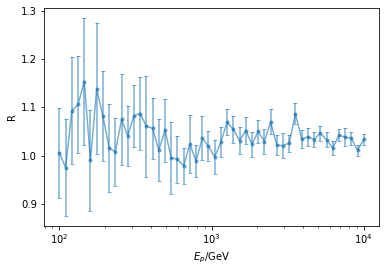

In [80]:
plt.errorbar(prim_energy, muon_ratio, yerr=muon_ratio_sigma/1e1,marker='.', capsize=2, alpha=0.6)
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("$E_p$/GeV")
plt.ylabel("R")
# plt.grid("on", which="both");

## Electron to muon ratio

In [64]:
runnums = np.arange(6000, 6017, 1, dtype=int)
zenith = np.zeros(runnums.size, dtype=float)
emu_ratio = np.zeros(runnums.size, dtype=float)
emu_ratio_sigma = np.zeros(runnums.size, dtype=float)
for i, runn in enumerate(runnums):
    ne, nmu = 0, 0
    with co.CorsikaParticleFile(f"DAT{runn:06d}") as f:
        _emu_ratio = np.zeros(int(f.run_header[21])) # NSHOW, number of events
        for j, event in enumerate(f):
            ids = event.particles["particle_description"] // 1000
            _n_e = np.sum(ids == 2) + np.sum(ids == 3) # number of e+ and e-
            _n_mu = np.sum(ids == 5) + np.sum(ids == 6) # number of mu+ and mu-
            if _n_e * _n_mu > 0:
                _emu_ratio[j] = _n_e / _n_mu # Store the charge ratios in each event
                ne += _n_e
                nmu += _n_mu
        zenith[i] = np.rad2deg(event.header[10]) # zenith angle in degree of last shower event
        # If no muons are produced, assign the ratio to NaN 
        emu_ratio[i] = ne / nmu if ne * nmu > 0 else np.nan
        emu_ratio_sigma[i] = np.sqrt(np.mean((_emu_ratio - emu_ratio[i])**2))


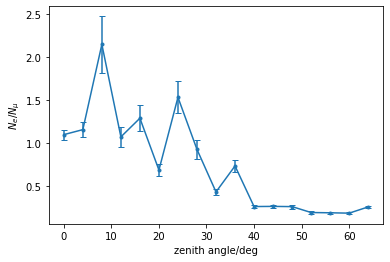

In [46]:
plt.errorbar(zenith, emu_ratio, yerr=emu_ratio_sigma/10, capsize=3, marker='.')
plt.ylabel("$N_e/N_{\mu}$")
plt.xlabel("zenith angle/deg");

## SLANT option on longitudinal development

Read average longitudinal development from .lst file,
including number of particles and (statistical) error.

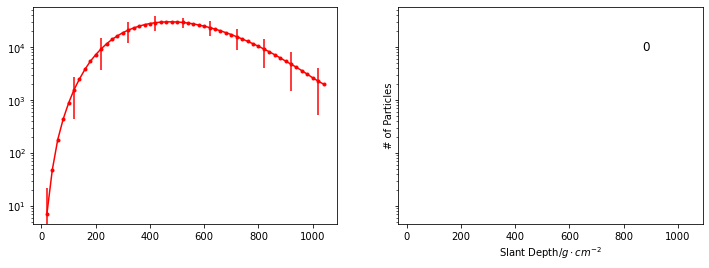

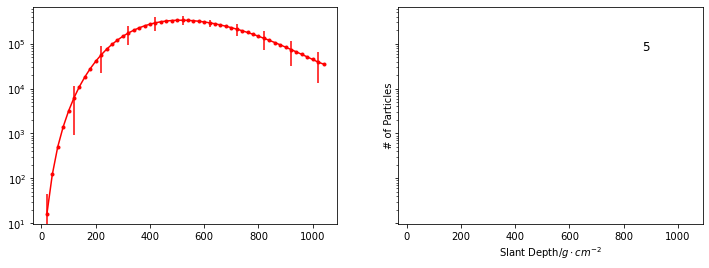

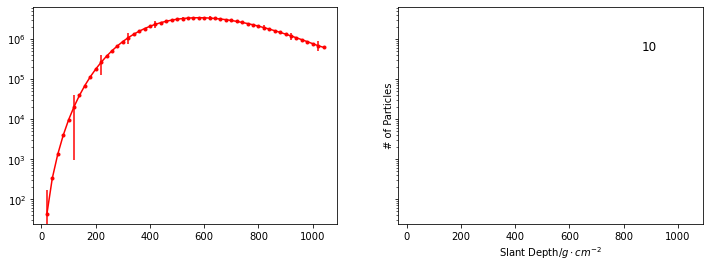

In [3]:
runnums = np.arange(0, 9, 1, dtype=int)
zenith = np.arange(0, 41, 5)
names = "depth gamma gamma_err positron positron_err electon electon_err mup mup_err mum mum_err".split(" ")
convert_func = lambda x: float(x.strip(b"+-"))
error_converter = dict(zip(names, [convert_func] * len(names)))

for i, runn in enumerate(runnums):
    output = subprocess.check_output(f"grep -n 'AVERAGE LONGITUDINAL PARTICLE' DAT{runn+9000:06d}.lst",
                                     shell=True)
    output = output.split(b'\n')[:-1]
    rownum1, rownum2 = [int(j.split(b':')[0]) for j in output]
    # print(runn, rownum1, rownum2)
    a = np.genfromtxt(f"DAT{runn+9000:06d}.lst",
                      skip_header=rownum1+4, max_rows=rownum2-rownum1-7,
                      names=names, converters=error_converter)
    output = subprocess.check_output(f"grep -n 'AVERAGE LONGITUDINAL PARTICLE' ./DAT{runn+10000:06d}.lst", shell=True)
    output = output.split(b'\n')[:-1]
    rownum1, rownum2 = [int(j.split(b':')[0]) for j in output]
    b = np.genfromtxt(f"DAT{runn+10000:06d}.lst",
                      skip_header=rownum1+3, max_rows=rownum2-rownum1-6,
                      names=names, converters=error_converter)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True, sharey=True)
    axs[0].errorbar(a["depth"], a["electon"], yerr=a['electon_err'],
                 color='red', marker='.', errorevery=10)
    axs[0].errorbar(b["depth"], b["electon"], yerr=b['electon_err'],
                 color='blue', marker='+', errorevery=10)
    axs[1].errorbar(a["depth"], a["electon"], yerr=a['electon_err'],
                 color='red', marker='.', errorevery=10)
    axs[1].errorbar(b["depth"] / np.cos(np.deg2rad(zenith[i])), b["electon"], yerr=b['electon_err'],
                 color='blue', marker='+', errorevery=10)
    plt.xlabel("Slant Depth/${g \cdot cm^{-2}}$")
    plt.ylabel("# of Particles")
    plt.yscale("log")
    plt.text(0.8, 0.8, f"{zenith[i]:.0f}", fontsize=12, transform=plt.gca().transAxes)
    # plt.savefig(f"slant_vertical.{zenith[i]}.png", dpi=500);

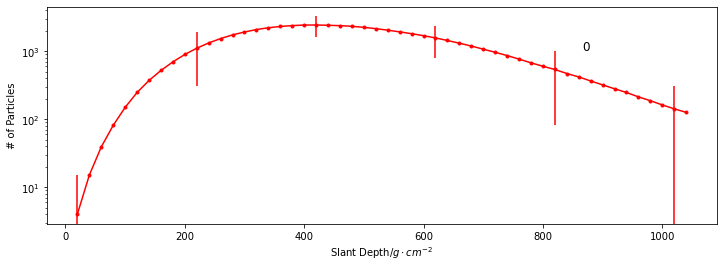

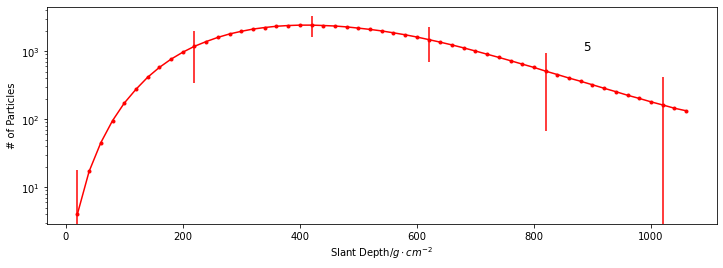

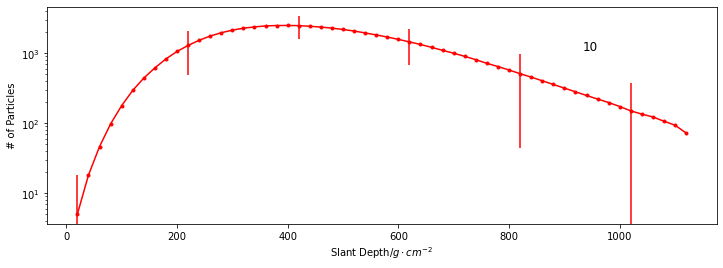

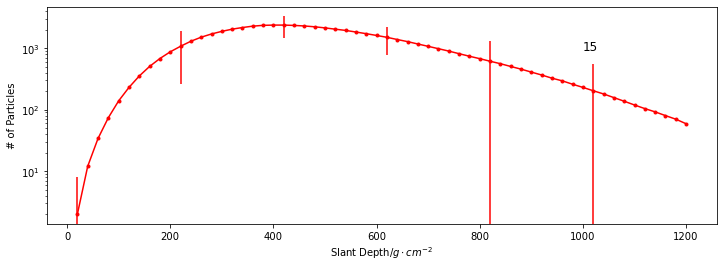

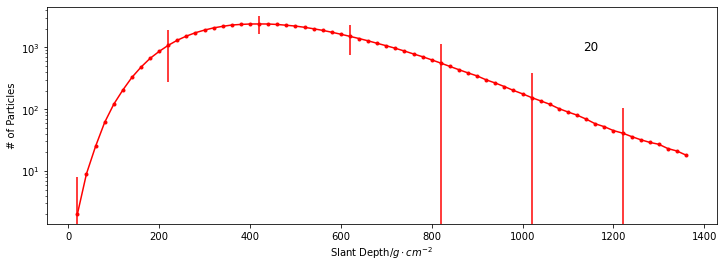

In [82]:
runnums = np.arange(0, 5, 1, dtype=int)
zenith = np.arange(0, 41, 5)
names = "depth gamma gamma_err positron positron_err electon electon_err mup mup_err mum mum_err".split(" ")
convert_func = lambda x: float(x.strip(b"+-"))
error_converter = dict(zip(names, [convert_func] * len(names)))

for i, runn in enumerate(runnums):
    output = subprocess.check_output(f"grep -n 'AVERAGE LONGITUDINAL PARTICLE' DAT{runn+20000:06d}.lst",
                                     shell=True)
    output = output.split(b'\n')[:-1]
    rownum1, rownum2 = [int(j.split(b':')[0]) for j in output]
    # print(runn, rownum1, rownum2)
    a = np.genfromtxt(f"DAT{runn+20000:06d}.lst",
                      skip_header=rownum1+4, max_rows=rownum2-rownum1-7,
                      names=names, converters=error_converter)
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 4), sharex=True, sharey=True)
    axs.errorbar(a["depth"], a["electon"], yerr=a['electon_err'],
              color='red', marker='.', errorevery=10)
    
    plt.xlabel("Slant Depth/${g \cdot cm^{-2}}$")
    plt.ylabel("# of Particles")
    plt.yscale("log")
    plt.text(0.8, 0.8, f"{zenith[i]:.0f}", fontsize=12, transform=plt.gca().transAxes)
    # plt.savefig(f"slant_vertical.{zenith[i]}.png", dpi=500);

## Lateral distribution of electron-to-muon ratio

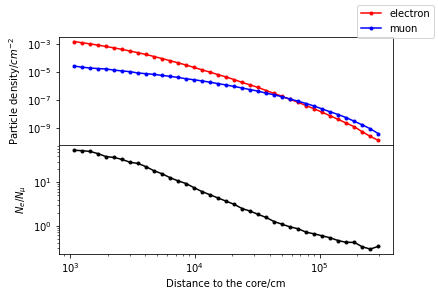

In [6]:
dist_bins = np.logspace(3, 5.5, 40)
# Bin centers at logarithm space
dist_bin_centers = np.power(10, (np.log10(dist_bins[1:]) + np.log10(dist_bins[:-1])) / 2)
dr = dist_bins[1:] - dist_bins[:-1]
for runn in range(21001, 21002):
    with co.CorsikaParticleFile(f"DAT{runn:06d}") as f:
        dist_e = np.array([], dtype=float)
        dist_m = np.array([], dtype=float)
        for j, event in enumerate(f):
            ids = event.particles["particle_description"] // 1000
            electrons = event.particles[(ids == 2) | (ids == 3)] # e+ and e-
            muons = event.particles[(ids == 5) | (ids == 6)] # mu+ and mu-
            dist_e = np.append(dist_e, np.sqrt(electrons["x"]**2 + electrons["y"]**2))
            dist_m = np.append(dist_m, np.sqrt(muons["x"]**2 + muons["y"]**2))
        # Use all showers for statitic, calculate lateral distribution for average
        nes, _ = np.histogram(dist_e, bins=dist_bins)
        nms, _ = np.histogram(dist_m, bins=dist_bins)
        nes = nes / (j + 1)
        nms = nms / (j + 1)
    
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
    axs[0].plot(dist_bin_centers, nes / (2 * np.pi * dist_bin_centers * dr),
                color='r', marker='.', label='electron')
    axs[0].plot(dist_bin_centers, nms / (2 * np.pi * dist_bin_centers * dr),
                color='b', marker='.', label='muon')
    axs[1].plot(dist_bin_centers, nes / nms, color='k', marker='.')
    axs[0].set_xscale("log")
    axs[0].set_yscale("log")
    axs[1].set_yscale("log")
    axs[0].set_ylabel("Particle density/${cm^{-2}}$")
    axs[1].set_ylabel(r"$N_e/N_{\mu}$")
    axs[1].set_xlabel("Distance to the core/cm")
    fig.legend()
    fig.subplots_adjust(hspace=0)


In [99]:
nes / (2 * np.pi * dist_bin_centers * dr)

array([6.30176215e-05, 5.18213835e-05, 4.35704876e-05, 3.45798788e-05,
       3.10485052e-05, 2.34942616e-05, 1.99554212e-05, 1.48191108e-05,
       1.31251145e-05, 9.49614932e-06, 7.20953883e-06, 5.14257700e-06,
       3.77961096e-06, 2.78142845e-06, 1.91989016e-06, 1.25048736e-06,
       9.73787213e-07, 7.05193908e-07, 4.43927184e-07, 3.24999919e-07,
       2.17325442e-07, 1.60451413e-07, 9.56900111e-08, 6.01426015e-08,
       4.24331956e-08, 2.41679695e-08, 1.57036412e-08, 1.13362276e-08,
       7.05197461e-09, 4.07491992e-09, 2.47696616e-09, 1.68604612e-09,
       7.55971522e-10, 5.46340106e-10, 3.17214154e-10, 1.39254955e-10,
       7.66172598e-11, 2.51613436e-11, 2.24755303e-11])

In [100]:
dist_bin_centers

array([  1076.59233153,   1247.82547047,   1446.29341966,   1676.32790423,
         1942.94961472,   2251.97778776,   2610.15721568,   3025.3054571 ,
         3506.48346153,   4064.19333198,   4710.60754198,   5459.83460973,
         6328.22702804,   7334.73817082,   8501.335966  ,   9853.48236346,
        11420.68906292,  13237.16163085,  15342.54606495,  17782.79410039,
        20611.16614402,  23889.39372621,  27689.02684196,  32092.99558798,
        37197.4201798 ,  43113.70885399,  49970.98944394,  57918.92770031,
        67130.9938683 ,  77808.24881744,  90183.73235937, 104527.54953204,
       121152.76586286, 140422.24027955, 162756.54480268, 188643.14387358,
       218647.03366402, 253423.07357913, 293730.27909897])

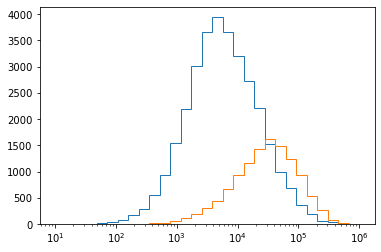

In [62]:
test_bins = np.logspace(1, 6, 30)
plt.hist(dist_e, bins=test_bins, histtype='step')
plt.hist(dist_m, bins=test_bins, histtype='step')
plt.xscale("log");

### Lateral Distribution from NKG

In [3]:
runn = 21000
nkgrow = int(subprocess.check_output(f'grep -n "LATERAL" DAT{runn:06d}.lst', shell=True).split(b":")[0])
lateral_nkg = np.genfromtxt(f"DAT{runn:06d}.lst", skip_header=nkgrow+2, max_rows=21)

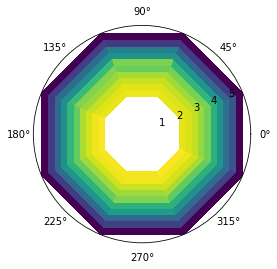

In [5]:
lateral_theta = np.arange(0, 2 * np.pi, np.pi/4)
lateral_r = lateral_nkg[11:,0]
lateral_nkg2D = np.zeros((10, 8))
lateral_nkg2D[:,:4] = lateral_nkg[11:,1:]
lateral_nkg2D[:,4:] = lateral_nkg[9::-1,1:]

ttheta, rr = np.meshgrid(lateral_theta, lateral_r)
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.pcolormesh(ttheta, np.log10(rr), np.log10(lateral_nkg2D), shading='nearest')

In [25]:
lateral_theta / np.pi

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75])

### (x, y) on ObsLev

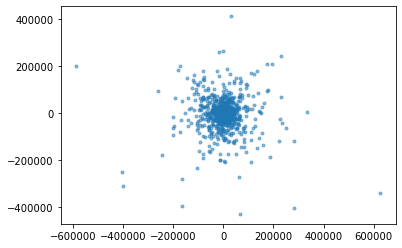

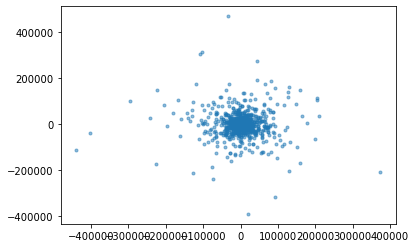

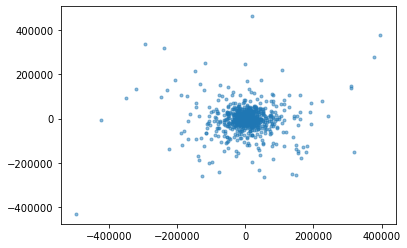

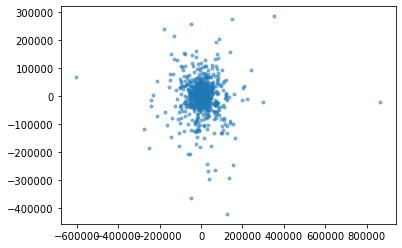

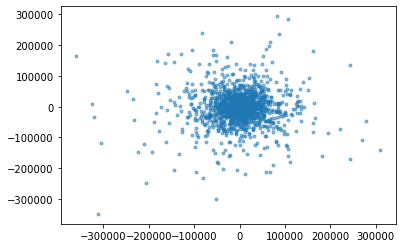

In [50]:
runn = 21000
with co.CorsikaParticleFile(f"DAT{runn:06d}") as f:
    for j, event in enumerate(f):
        if j > 4: break
        ids = event.particles["particle_description"] // 1000
        electrons = event.particles[(ids == 2) | (ids == 3)] # e+ and e-
        muons = event.particles[(ids == 5) | (ids == 6)] # mu+ and mu-
        plt.figure()
        # plt.plot(electrons["x"], electrons["y"], marker='.', ls="None", alpha=0.5)
        plt.plot(muons["x"], muons["y"], marker='.', ls="None", alpha=0.5)
        # plt.xlim(-electrons["x"].max(), electrons["x"].max)
        # plt.ylim(-electrons["y"].max(), electrons["y"].max)